<a href="https://colab.research.google.com/github/jkarenko/Function-Approximation/blob/main/Function_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

genetic algorithm to approximate a transfer function

In [822]:
import random
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
from decimal import Decimal

In [823]:
target_neg = {
    -1: -.58,
    -.9: -.57,
    -.8: -.56,
    -.7: -.54,
    -.6: -.50,
    -.5: -.45,
    -.4: -.40,
    -.3: -.36,
    -.2: -.23,
    -.1: -.11,
    0: 0,
}
target_pos = {
    0.: 0.,
    .1: .11,
    .2: .26,
    .3: .39,
    .4: .54,
    .5: .64,
    .6: .82,
    .7: .86,
    .8: .87,
    .9: .88,
    1: .88
}

pos = list(target_pos.values())
np.asarray(pos)*.5

array([0.   , 0.055, 0.13 , 0.195, 0.27 , 0.32 , 0.41 , 0.43 , 0.435,
       0.44 , 0.44 ])

In [824]:
class Genome:
  def __init__(self, n) -> None:
    self.n = n
    self.fitness = float("inf")
    self.lookup_table = {}
    self.transfer_function = ""

  def get_equation(self):
    equation = ""
    for i, nth in enumerate(self.n):
      value = self.n[nth]
      #value_frac = Fraction(np.round(value, decimals=4)).limit_denominator(1000)
      value_frac = Fraction(value).limit_denominator(100)
      fraction_str = r"{"+str(abs(value_frac.numerator))+"}{"+str(value_frac.denominator)+"}"
      x = r"\mathcal{x}"
      new_part = r"\frac{} {}".format(fraction_str, x)
      if i > 0:
        new_part = new_part + "^{}".format(nth)
      equation = new_part + equation
      if i < len(self.n) - 1 and value >= 0:
        equation = " + " + equation
      elif value < 0:
        equation = " - " + equation
    #equation = "f(x) = " + equation
    return equation

  def get_equation_math(self):
    equation = ""
    for i, nth in enumerate(self.n):
      value = np.round(self.n[nth], decimals=4)
      new_part = str(value) + "*x"
      if i > 0:
        new_part = new_part + "**{}".format(nth)
      equation = new_part + equation
      if i < len(self.n) - 1 and value >= 0:
        equation = "+" + equation
      #elif value < 0:
      #  equation = "-" + equation
    return equation

  def __str__(self):
    newline = "\n"
    return f"Function={self.get_equation()}\nfitness={self.fitness}\nValues from input:\n{f'{newline}'.join(list(map(lambda x: f'{x} -> {self.lookup_table[x]}', self.lookup_table.keys())))}"


In [825]:
def f(input, n):
  equation = ""
  for i, nth in enumerate(n):
    value = n[nth]
    equation = f"{value} * {input} ** {nth}" + equation
    if i < len(n) - 1:
      equation = " + " + equation
  #print(equation)
  return eval(equation)
#res = f(0.1, {1: .23, 2: .6, 3: .83})
#print(res)

In [826]:
def test_fitness(input, genome, target):
  results = {}
  for i in input:
    results[i] = f(i, genome.n)
  fitness = 0
  for in_val in results:
    out_val = results[in_val]
    target_val = target[in_val]
    if out_val < 0 and target_val < 0:
      fitness = fitness + abs(abs(target_val) - abs(out_val))
    elif out_val < 0 and target_val >= 0:
      fitness = fitness + target_val + abs(out_val)
    elif out_val >= 0 and target_val < 0:
      fitness = fitness + abs(target_val) + out_val
    else:
      fitness = fitness + abs(target_val - out_val)
  genome.fitness = fitness / len(target)
  genome.lookup_table = results
  return genome

In [827]:
def make_random_genome(order):
  n = {}
  for i in range(1, order + 1):
    n[i] = np.random.uniform(-1, 1)
  return Genome(n)
#make_random_genome(order=4).n

In [828]:
def new_genome_from_parents(p1, p2, mutation=.05):
  n = {}
  for i in p1.n:
    n[i] = np.random.choice((p1.n[i], p2.n[i])) * (1 + np.random.uniform(-1 * mutation, mutation))
  return Genome(n)
#new_genome_from_parents(make_random_genome(4), make_random_genome(4)).n

In [829]:
#input_values = np.round(np.arange(-1, 1, 0.1), decimals=2)


def approximate_function():
  winner = {}
  num_candidates = 100
  num_generations = 100
  num_of_best = int(np.floor(num_candidates/10))
  num_mates_for_best = 10
  order = 9
  for index, target in enumerate([target_pos, target_neg]):
    input_values = target.keys()
    candidates = []
    for _ in range(0,num_candidates):
      candidates.append(make_random_genome(order))
    for generation in range(0, num_generations):

      for genome in candidates:
        genome = test_fitness(input_values, genome, target).fitness

      candidates.sort(key = lambda x: x.fitness)

      best_genomes = candidates[:num_of_best]

      # print(f"\nBest of generation {generation}: {best_genomes[0].fitness}")

      new_generation = []
      for i in range(0, num_of_best):
        for j in range(i + 1, i + num_mates_for_best):
          new_generation.append(new_genome_from_parents(best_genomes[i], candidates[j]))
        
      candidates = best_genomes + new_generation
      # print(len(candidates))

    winner[index] = candidates[0]
    #print(f"Best genome after {num_generations} generations:")
    #print(winner[index])
    #for i, k in enumerate(target):
    #  print(f"{k} -> {target[k]}")
  return winner

In [830]:
#winner = approximate_function()

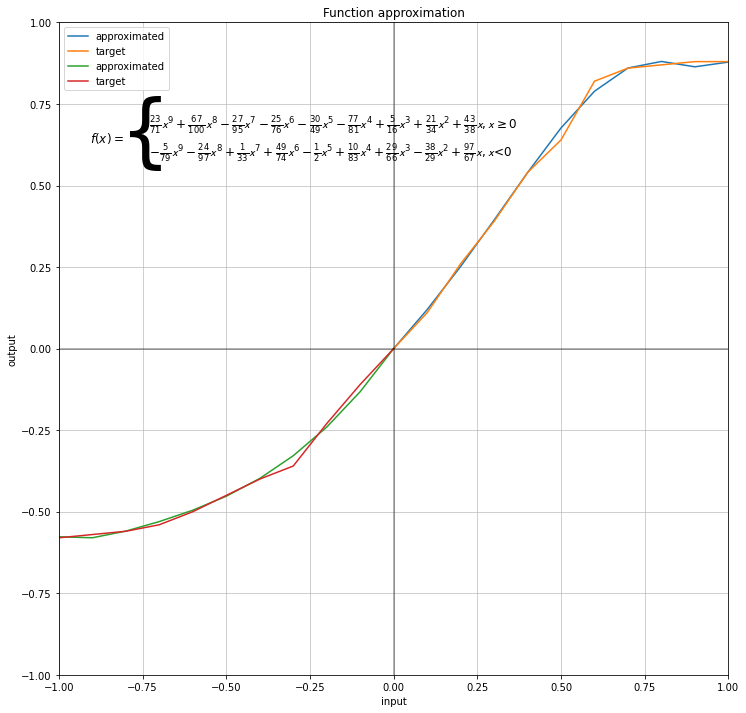

In [831]:
winner = approximate_function()
input_pos = list(winner[0].lookup_table.keys())
output_pos = list(winner[0].lookup_table.values())
target_values_pos = list(target_pos.values())

input_neg = list(winner[1].lookup_table.keys())
output_neg = list(winner[1].lookup_table.values())
target_values_neg = list(target_neg.values())

equation_pos = winner[0].get_equation()
equation_neg = winner[1].get_equation()

plt.figure(figsize=(12,12))

plt.title(r"Function approximation")

plt.plot(input_pos, output_pos, label="approximated")
plt.plot(input_pos, target_values_pos, label="target")

plt.plot(input_neg, output_neg, label="approximated")
plt.plot(input_neg, target_values_neg, label="target")

x = 12/100
y = 80/100

plt.annotate("$f(x) = $", xy=(x, y), xycoords="figure fraction", fontsize=12)
plt.annotate("$\{$", xy=(x + 4/100, y -2/100), xycoords="figure fraction", fontsize=80)
plt.annotate("$"+equation_pos+", \mathcal{x} \geq 0$", xy=(x + 8/100, y + 2/100), xycoords="figure fraction", fontsize=12)
plt.annotate("$"+equation_neg+", \mathcal{x} \less 0$", xy=(x + 8/100, y + -2/100), xycoords="figure fraction", fontsize=12)

plt.grid(alpha=.75)
plt.axhline(color="black", alpha=.4)
plt.axvline(color="black", alpha=.4)
plt.legend()

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.ylabel("output")
plt.xlabel("input")
plt.show()

In [832]:
winner[0].get_equation_math()

'0.3241*x**9+0.669*x**8-0.2847*x**7-0.3289*x**6-0.6122*x**5-0.9505*x**4+0.3123*x**3+0.6177*x**2+1.1317*x'